# Probablistic model for spot latitude distribution

Load spots properties from `friedrich`:

In [1]:
%matplotlib inline
# Import dev version of friedrich:
import sys
sys.path.insert(0, '../')

import numpy as np
import matplotlib.pyplot as plt
from friedrich.analysis import Transit, Spot, Measurement, MCMCResults
from friedrich.lightcurve import hat11_params_morris_flip_lambda
from glob import glob

archive_paths = sorted(glob('/local/tmp/friedrich/hat11_flip_lambda/chains???.hdf5'))
#archive_paths = sorted(glob('/local/tmp/friedrich/hat11_init/chains???.hdf5'))
print('load results')
transits = []
all_times = []
for archive_path in archive_paths:
    m = MCMCResults(archive_path, hat11_params_morris_flip_lambda())
    all_times.extend(m.lc.times.jd)
    spots = m.get_spots()
    transits.append(Transit(spots))


load results


In [2]:
from friedrich.orientation import times_to_occulted_lat_lon
from friedrich.lightcurve import hat11_params_morris_flip_lambda

transit_params = hat11_params_morris_flip_lambda()
all_lats = []
all_lons = []
all_amps = []
all_lats_errors = []
all_spot_times = []
all_BICs = []
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params)
        all_lats.append(latitude)
        all_lons.append(longitude)
        all_amps.append(spot.amplitude.value)
        all_spot_times.append(spot.t0.value)
        all_BICs.append(spot.delta_BIC)
        all_lats_errors.append(np.mean([spot.amplitude.upper, spot.amplitude.lower]))
all_lats = np.array(all_lats)
all_lats_errors = np.array(all_lats_errors)
all_lons = np.array(all_lons)
all_amps = np.array(all_amps)
all_spot_times = np.array(all_spot_times)
all_BICs = np.array(all_BICs)

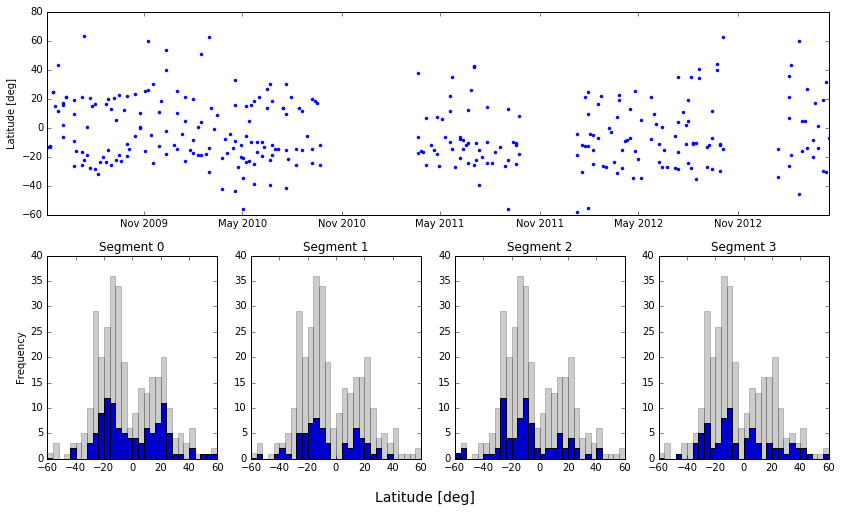

In [3]:
#all_amps
# plt.plot_date(Time(all_spot_times[all_BICs > 10], format='jd').plot_date, 
#               np.degrees(all_lats[all_BICs > 10]), '.')
from astropy.time import Time

n_panels = 4
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 4)
ax0 = plt.subplot(gs[0, :])
ax1 = [plt.subplot(gs[1, i]) for i in range(n_panels)]

#fig, ax = plt.subplots(1, n_panels, figsize=(14, 3))
first_spot = all_spot_times[all_BICs > 10].min()
last_spot = all_spot_times[all_BICs > 10].max()
first_to_last = last_spot - first_spot
fraction_gt_median = np.zeros(n_panels)

ax0.plot_date(Time(all_spot_times[all_BICs > 10], format='jd').plot_date, 
              np.degrees(all_lats[all_BICs > 10]), '.')

for i in range(n_panels):
    extent = [-60, 60]
    within_time_bin = ((all_spot_times[all_BICs > 10] - first_spot > 
                        i/n_panels*first_to_last) & 
                       (all_spot_times[all_BICs > 10] - first_spot < 
                        (i+1)/n_panels*first_to_last))
    lats_in_time_bin = np.degrees(all_lats[all_BICs > 10][within_time_bin])
    ax1[i].hist(lats_in_time_bin, 30, range=extent)

    ax1[i].hist(np.degrees(all_lats[all_BICs > 10]), 30,
                range=extent, alpha=0.2, color='k', zorder=10)

    ax1[i].set_xlim(extent)
    
    ax1[i].set(title='Segment {0}'.format(i))
    
    if i == 0:
        segment_zero_mean = np.median(lats_in_time_bin)
    fraction_gt_median[i] = np.count_nonzero(lats_in_time_bin > segment_zero_mean)/len(lats_in_time_bin)

ax1[0].set_ylabel('Frequency')
ax0.set_ylabel('Latitude [deg]')

fig.text(0.5, 0.05, 'Latitude [deg]', ha='center', fontsize=14)

#fig.subplots_adjust()

In [4]:
ignore_high_latitudes = ((all_lats > np.radians(-40)) & (all_lats < np.radians(50)))
significance_cutoff = np.atleast_2d(all_BICs > 10).T
significant_latitudes = np.degrees(all_lats[significance_cutoff & ignore_high_latitudes])

significant_latitudes_errors = np.ones_like(significant_latitudes) * 2

# Gaussian mixture model with scikit-learn

Note that it is not well physically motivated to model the distribution as three gaussians, because while it may be a good approximation to model the active latitudes with Gaussians, the perhaps uniform background of spots distributed isotropically on the surface of the star would be modeled with a cosine function.  

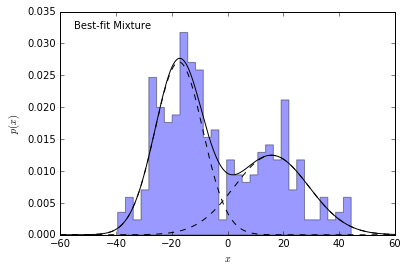

In [136]:
from sklearn.mixture import GMM

X = np.atleast_2d(significant_latitudes).T

fig, ax = plt.subplots()
M_best = GMM(2).fit(X)#models[np.argmin(AIC)]

x = np.atleast_2d(np.linspace(-60, 60, 1000)).T
# logprob, responsibilities = M_best.eval(x)
logprob = M_best.score(x)
responsibilities = M_best.predict_proba(x)

pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, normed=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

# Modified Gaussian Mixture Model with `emcee`

...with a cosine-bias centered on the stellar equator.

In [6]:
from scipy.integrate import quad
quad(lambda x: np.cos(2*x), -np.pi/4, np.pi/4)

(1.0, 1.1102230246251565e-14)

In [74]:
90 - transit_params.inc_stellar

10

In [88]:
import emcee
from scipy.misc import logsumexp

def gaussian(x, mean, lnvar, amp):
    var = np.exp(lnvar)
    return amp/np.sqrt(2*np.pi*var) * np.exp(-0.5 * (x - mean)**2 / var)

def cosine(x, x0, amp):
    y = amp * np.cos(np.radians(x - x0))
    visible_hemisphere = (-90 < x - x0) & (x - x0 < 90)
    y[~visible_hemisphere] = 0
    return y

def lnlikelihood_gaussian(x, yerr, mean, lnvar, amp):
    var = np.exp(lnvar) + yerr**2
#     return  -0.5 * (x - mean)**2 / var - 0.5 * np.log(2*np.pi*var) + np.log(amp)
    return  -0.5 * ((x - mean)**2 / var + np.log(var)) + np.log(amp)

def lnlikelihood_cosine(x, yerr, x0, amp):
    return -0.5 * (((cosine(x, x0, amp) - x) / yerr)**2 + 2*np.log(yerr))
    
def lnlikelihood_sum_gaussians(parameters, x, yerr):
    a1, m1, v1, a2, m2, v2 = parameters
    a3 = 1
    x0 = transit_params.inc_stellar - 90

    ln_likes = (np.logaddexp(lnlikelihood_cosine(x, yerr, x0, a3), 
                             lnlikelihood_gaussian(x, yerr, m1, v1, a1)),
                np.logaddexp(lnlikelihood_cosine(x, yerr, x0, a3), 
                             lnlikelihood_gaussian(x, yerr, m2, v2, a2)))
    return np.sum(np.logaddexp.reduce(ln_likes)), ln_likes

def minimize_this(parameters, x, yerr):
    return -1*lnlikelihood_sum_gaussians(parameters, x, yerr)

def model(parameters, x):
    a1, m1, v1, a2, m2, v2 = parameters
    a3 = 1
    x0 = np.pi/2 - np.radians(transit_params.inc_stellar)
    return (cosine(x, x0, a3) * gaussian(x, m1, v1, a1) + 
            cosine(x, x0, a3) * gaussian(x, m2, v2, a2))

def lnprior(parameters):
    a1, m1, v1, a2, m2, v2 = parameters
    variances = np.exp([v1, v2])
    means = np.array([m1, m2])
    
    if (a1 <= 1 - a2 and a2 <= 1 - a1 and 0 <= a1 <= 1 and 0 <= a2 <= 1 and 
        np.all(variances < 50**2) and np.all(variances > 0) and
        np.all(-50 < means) and np.all(means < 50) and m1 < m2):
        return 0.0
    return -np.inf

def lnprob(parameters, x, yerr):
    lp = lnprior(parameters)
    if not np.isfinite(lp):
        return -np.inf, None
    lnlike, blobs = lnlikelihood_sum_gaussians(parameters, x, yerr)
    return lp + lnlike, blobs

initp = [0.4, -19, np.log(9**2), 0.5, 19, np.log(9**2)]

ndim, nwalkers = len(initp), 4*len(initp)
p0 = [np.array(initp) + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(significant_latitudes, significant_latitudes_errors),
                                threads=4)

pos = sampler.run_mcmc(p0, 500)[0]
samples = sampler.run_mcmc(pos, 15000)

[  0.63964858 -17.85184505   4.08890561   0.35710604  20.87998507
   4.57121492]


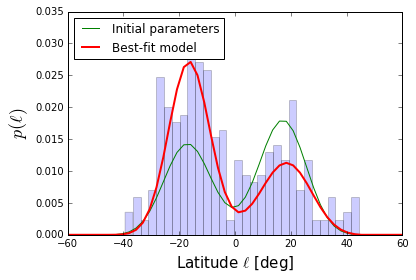

In [89]:
burnin = 10000
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

bestp = np.median(samples, axis=0)

plt.hist(significant_latitudes, 30, normed=True, alpha=0.2)
test_lats = np.linspace(-60, 60)
plt.plot(test_lats, model(initp, test_lats), label='Initial parameters')
plt.plot(test_lats, model(bestp, test_lats), lw=2, label='Best-fit model')
plt.legend(loc='upper left')
plt.xlabel('Latitude $\ell$ [deg]', fontsize=15)
plt.ylabel('$p(\ell)$', fontsize=18)
print(bestp)

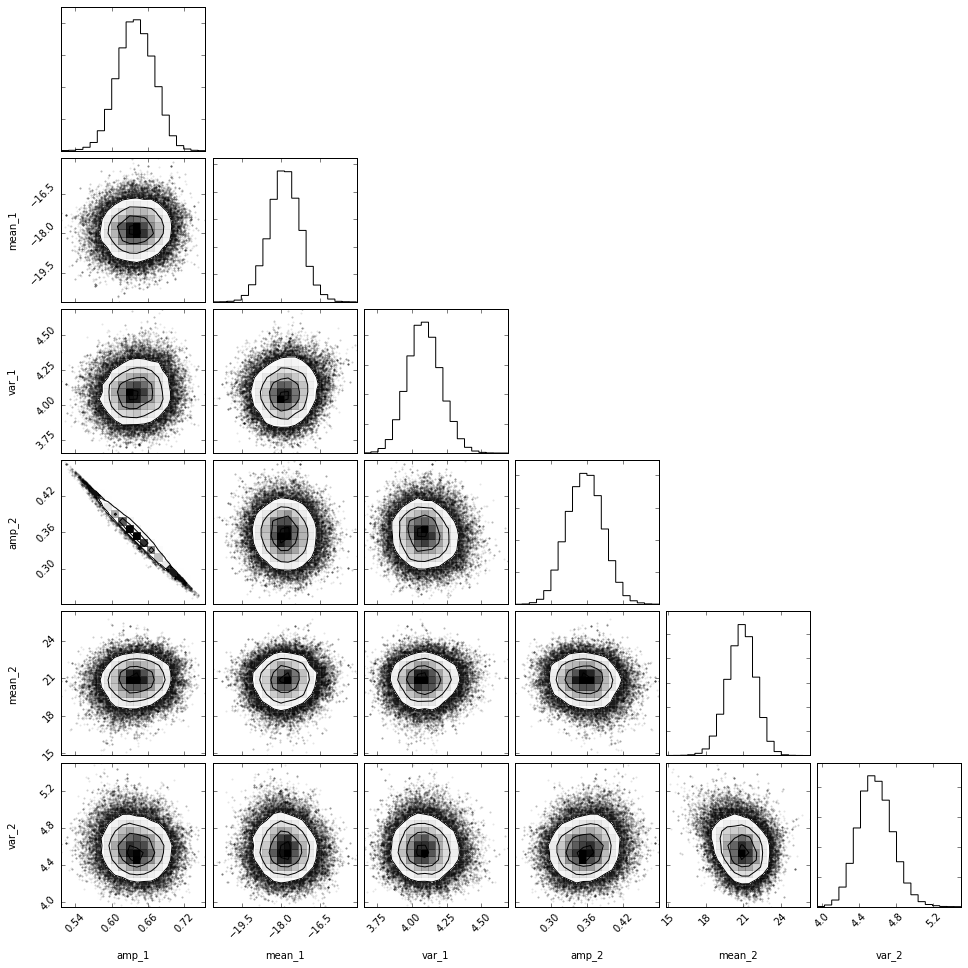

In [90]:
import corner 

# a1, m1, v1, a2, m2, v2
labels = "amp_1, mean_1, var_1, amp_2, mean_2, var_2".split(', ')
fig = corner.corner(samples, labels=labels)

/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


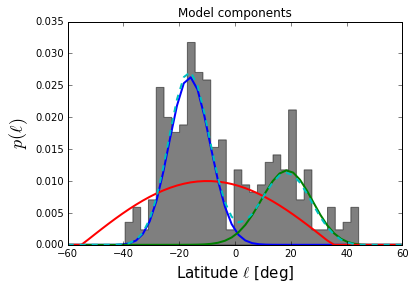

In [94]:
components = np.array([gaussian(test_lats, bestp[1], bestp[2], bestp[0]) * 
                       cosine(test_lats, (bestp[1] + bestp[4])/2, 1), 
                       gaussian(test_lats, bestp[4], bestp[5], bestp[3]) * 
                       cosine(test_lats, (bestp[1] + bestp[4])/2, 1), 
                       0.01*cosine(test_lats, transit_params.inc_stellar - 90, 1)]).T

plt.hist(significant_latitudes, 30, normed=True, 
         alpha=0.5, histtype='stepfilled', color='k')

plt.title('Model components')
plt.plot(test_lats, components, lw=2)
plt.plot(test_lats, model(bestp, test_lats), ls='--', lw=2)
plt.legend(loc='upper left')
plt.xlabel('Latitude $\ell$ [deg]', fontsize=15)
plt.ylabel('$p(\ell)$', fontsize=18)
plt.show()

In [92]:
print("Gaussian 1 properties: \n\tmean={0:.2f} deg  std={1:.2f} deg  amp={2:.2f}"
      .format(bestp[1], np.exp(bestp[2])**0.5, bestp[0]))

print("Gaussian 2 properties: \n\tmean={0:.2f} deg  std={1:.2f} deg  amp={2:.2f}"
      .format(bestp[4], np.exp(bestp[5])**0.5, bestp[3]))

Gaussian 1 properties: 
	mean=-17.85 deg  std=7.72 deg  amp=0.64
Gaussian 2 properties: 
	mean=20.88 deg  std=9.83 deg  amp=0.36


In [93]:
angle_between_means = bestp[4] - bestp[1]
print("Angle between the two gaussian means: {0:.2f} deg".format(angle_between_means))
print("Thus the active latitudes are at: +/- {0:.2f} deg".format(angle_between_means/2))
print("Sanchis-Ojeda & Winn put the latitudes at: 19.3 deg")

Angle between the two gaussian means: 38.73 deg
Thus the active latitudes are at: +/- 19.37 deg
Sanchis-Ojeda & Winn put the latitudes at: 19.3 deg


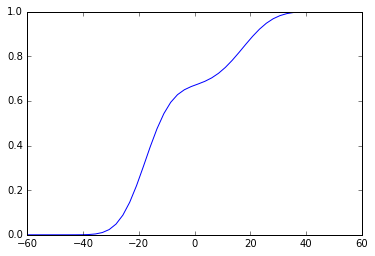

In [59]:
cdf = np.cumsum(model(bestp, test_lats))
cdf /= np.max(cdf)

pred_lat = lambda x: np.interp(x, cdf, test_lats)

plt.plot(test_lats, cdf)

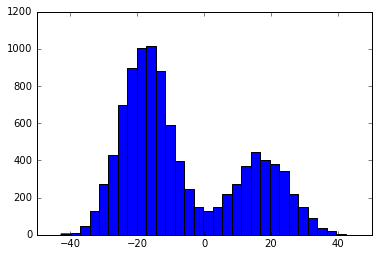

In [60]:
plt.hist(pred_lat(np.random.rand(10000)), 30);

In [101]:
import emcee
from scipy.misc import logsumexp

def gaussian_cos(x, mean, lnvar, amp, x0):
    var = np.exp(lnvar)
    return amp/np.sqrt(2*np.pi*var) * np.exp(-0.5 * (x - mean)**2 / var) / np.cos(np.radians(x - x0))

def cosine(x, x0, amp):
    y = amp * np.cos(np.radians(x - x0))
    visible_hemisphere = (-90 < x - x0) & (x - x0 < 90)
    y[~visible_hemisphere] = 0
    return y

def lnlikelihood_gaussian_cos(x, yerr, mean, lnvar, amp, x0):
    var = np.exp(lnvar) + yerr**2
#     return  -0.5 * (x - mean)**2 / var - 0.5 * np.log(2*np.pi*var) + np.log(amp)
    return  -0.5 * ((x - mean)**2 / var + np.log(var)) + np.log(amp) - np.log(np.cos(np.radians(x - x0)))

def lnlikelihood_cosine(x, yerr, x0, amp):
    return -0.5 * (((cosine(x, x0, amp) - x) / yerr)**2 + 2*np.log(yerr))
    
def lnlikelihood_sum_gaussians(parameters, x, yerr):
    a1, m1, v1, a2, m2, v2 = parameters
    a3 = 1
    x0 = transit_params.inc_stellar - 90

    ln_likes = (lnlikelihood_gaussian_cos(x, yerr, m1, v1, a1, x0),
                lnlikelihood_gaussian_cos(x, yerr, m2, v2, a2, x0))
    return np.sum(np.logaddexp.reduce(ln_likes)), ln_likes

def minimize_this(parameters, x, yerr):
    return -1*lnlikelihood_sum_gaussians(parameters, x, yerr)

def model(parameters, x):
    a1, m1, v1, a2, m2, v2 = parameters
    a3 = 1
    x0 = np.pi/2 - np.radians(transit_params.inc_stellar)
    return (gaussian(x, m1, v1, a1) + gaussian(x, m2, v2, a2))/cosine(x, x0, a3)

def lnprior(parameters):
    a1, m1, v1, a2, m2, v2 = parameters
    variances = np.exp([v1, v2])
    means = np.array([m1, m2])
    
    if (a1 <= 1 - a2 and a2 <= 1 - a1 and 0 <= a1 <= 1 and 0 <= a2 <= 1 and 
        np.all(variances < 50**2) and np.all(variances > 0) and
        np.all(-50 < means) and np.all(means < 50) and m1 < m2):
        return 0.0
    return -np.inf

def lnprob(parameters, x, yerr):
    lp = lnprior(parameters)
    if not np.isfinite(lp):
        return -np.inf, None
    lnlike, blobs = lnlikelihood_sum_gaussians(parameters, x, yerr)
    return lp + lnlike, blobs

/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


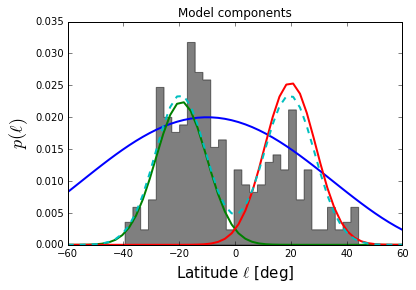

In [108]:
initp = [0.5, -19, np.log(9**2), 0.5, 19, np.log(9**2)]

plt.hist(significant_latitudes, 30, normed=True, 
         alpha=0.5, histtype='stepfilled', color='k')

x0 = transit_params.inc_stellar - 90
sort_of_cos_model = 0.02*cosine(test_lats, x0, 1)
components = np.array([sort_of_cos_model,
                       gaussian_cos(test_lats, initp[1], initp[2], initp[0], x0), 
                       gaussian_cos(test_lats, initp[4], initp[5], initp[3], x0),]).T

plt.title('Model components')
plt.plot(test_lats, components, lw=2)
plt.plot(test_lats, model(initp, test_lats), ls='--', lw=2)
plt.legend(loc='upper left')
plt.xlabel('Latitude $\ell$ [deg]', fontsize=15)
plt.ylabel('$p(\ell)$', fontsize=18)
plt.show()

In [109]:
initp = [0.4, -19, np.log(9**2), 0.5, 19, np.log(9**2)]

ndim, nwalkers = len(initp), 4*len(initp)
p0 = [np.array(initp) + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(significant_latitudes, significant_latitudes_errors),
                                threads=4)

pos = sampler.run_mcmc(p0, 500)[0]
samples = sampler.run_mcmc(pos, 15000)

[  0.6015026  -17.04684487   4.30857537   0.39530465  17.07857039
   5.01848592]


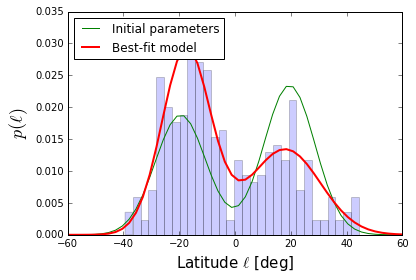

In [110]:
burnin = 10000
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

bestp = np.median(samples, axis=0)

plt.hist(significant_latitudes, 30, normed=True, alpha=0.2)
test_lats = np.linspace(-60, 60)
plt.plot(test_lats, model(initp, test_lats), label='Initial parameters')
plt.plot(test_lats, model(bestp, test_lats), lw=2, label='Best-fit model')
plt.legend(loc='upper left')
plt.xlabel('Latitude $\ell$ [deg]', fontsize=15)
plt.ylabel('$p(\ell)$', fontsize=18)
print(bestp)

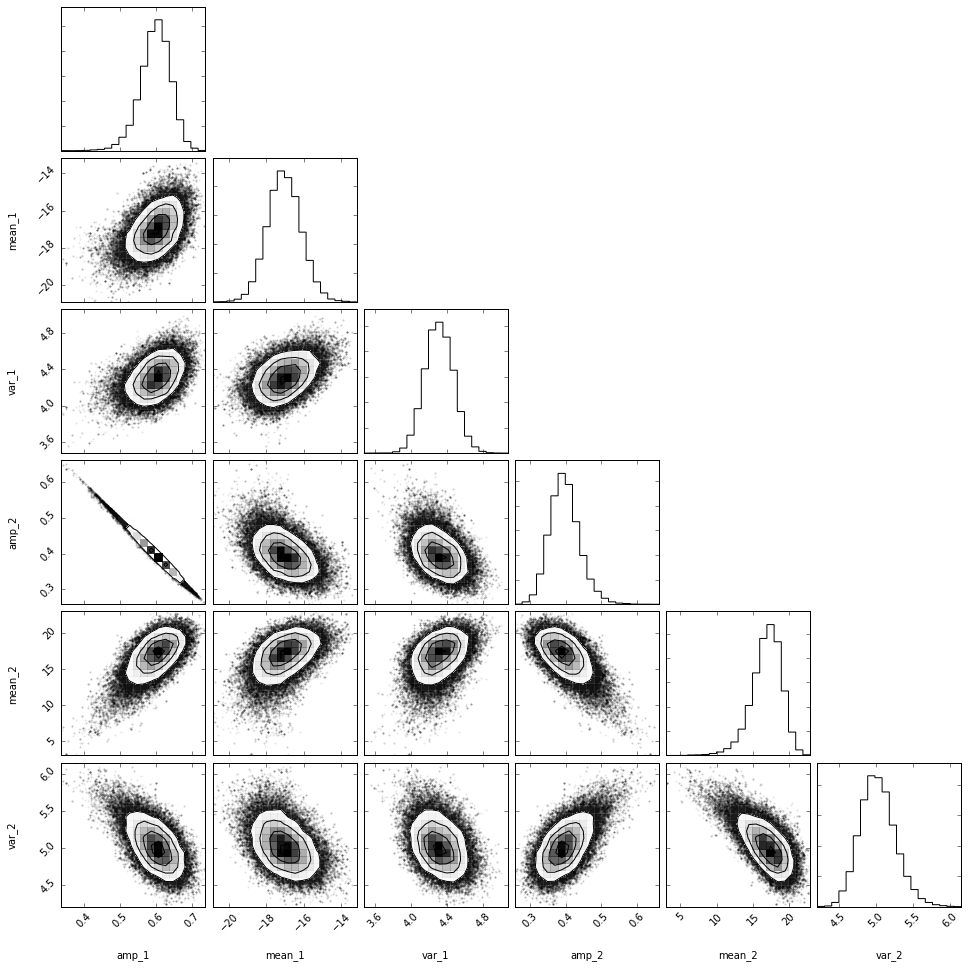

In [111]:
import corner 

# a1, m1, v1, a2, m2, v2
labels = "amp_1, mean_1, var_1, amp_2, mean_2, var_2".split(', ')
fig = corner.corner(samples, labels=labels)

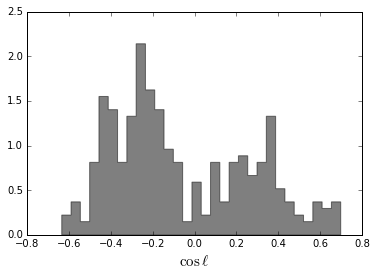

In [135]:
cos_significant_latitudes = np.zeros_like(significant_latitudes)
lat_gt_0 = significant_latitudes >= 0
lat_lt_0 = significant_latitudes < 0
cos_significant_latitudes = np.cos(np.pi/2 - np.radians(significant_latitudes))

cos_significant_latitudes
plt.hist(cos_significant_latitudes, 30, normed=True, 
         alpha=0.5, histtype='stepfilled', color='k')

# x0 = transit_params.inc_stellar - 90
# sort_of_cos_model = 0.02*cosine(test_lats, x0, 1)**4
# components = np.array([sort_of_cos_model,
#                        gaussian_cos(test_lats, bestp[1], bestp[2], bestp[0], x0), 
#                        gaussian_cos(test_lats, bestp[4], bestp[5], bestp[3], x0),]).T

# plt.title('Model components')
# plt.plot(test_lats, components, lw=2)
# plt.plot(test_lats, model(initp, test_lats), ls='--', lw=2)
# plt.legend(loc='upper left')
plt.xlabel('$\cos \, \ell$', fontsize=15)
# plt.ylabel('$p(\ell)$', fontsize=18)
# plt.show()

plt.show()

In [ ]:
# def binomial(n, r, p): 
#     return np.math.factorial(n)/np.math.factorial(r)/np.math.factorial(n-r) * p**r * (1-p)**(n-r)